1. Imports

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# %load_ext autoreload
#%autoreload 2

# import re

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler

from sklearn.linear_model import LinearRegression, LogisticRegression


from sklearn.metrics import mean_squared_error
from sklearn.metrics import recall_score

import joblib

In [5]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [6]:
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [7]:
df.ever_married.value_counts()

ever_married
Yes    3353
No     1757
Name: count, dtype: int64

In [8]:
df.gender.value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

2. Data Analysis

In [9]:
df.describe().applymap(lambda x: round(x, 3))

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000,5110.000,5110.000,5110.000,5110.000,4909.000,5110.000
mean,36517.829,43.227,0.097,0.054,106.148,28.893,0.049
std,21161.722,22.613,0.297,0.226,45.284,7.854,0.215
min,67.000,0.080,0.000,0.000,55.120,10.300,0.000
25%,17741.250,25.000,0.000,0.000,77.245,23.500,0.000
50%,36932.000,45.000,0.000,0.000,91.885,28.100,0.000
75%,54682.000,61.000,0.000,0.000,114.090,33.100,0.000
max,72940.000,82.000,1.000,1.000,271.740,97.600,1.000


In [10]:
# plt.figure(figsize = (50,50))
# sns.heatmap(round(df.corr(),2), cmap = "coolwarm", annot = True, annot_kws = {"size":12})

In [227]:
# plt.figure(figsize=(15,4))

# sns.regplot(x='age', y='stroke', data=df.sample(100, random_state=9), ci=95)

In [12]:
df.nunique()[df.nunique() == 2]

hypertension      2
heart_disease     2
ever_married      2
Residence_type    2
stroke            2
dtype: int64

In [13]:
df.drop(columns=['id']).nunique()[df.nunique() != 2]

gender                  3
age                   104
work_type               5
avg_glucose_level    3979
bmi                   418
smoking_status          4
dtype: int64

In [14]:
# Display numerics columns
df.select_dtypes(include=['int64', 'float64'])

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,9046,67.0,0,1,228.69,36.6,1
1,51676,61.0,0,0,202.21,NaN,1
2,31112,80.0,0,1,105.92,32.5,1
3,60182,49.0,0,0,171.23,34.4,1
4,1665,79.0,1,0,174.12,24.0,1
...,...,...,...,...,...,...,...
5105,18234,80.0,1,0,83.75,NaN,0
5106,44873,81.0,0,0,125.20,40.0,0
5107,19723,35.0,0,0,82.99,30.6,0
5108,37544,51.0,0,0,166.29,25.6,0


In [15]:
# Display Objects columns
df.select_dtypes(include=['O'])

,gender,ever_married,work_type,Residence_type,smoking_status
0,Male,Yes,Private,Urban,formerly smoked
1,Female,Yes,Self-employed,Rural,never smoked
2,Male,Yes,Private,Rural,never smoked
3,Female,Yes,Private,Urban,smokes
4,Female,Yes,Self-employed,Rural,never smoked
...,...,...,...,...,...
5105,Female,Yes,Private,Urban,never smoked
5106,Female,Yes,Self-employed,Urban,never smoked
5107,Female,Yes,Self-employed,Rural,never smoked
5108,Male,Yes,Private,Rural,formerly smoked


In [16]:
# curves_step = [1, 200, 300, 400, 500, 600, 650, 712]
# train_sizes, train_scores, test_scores = learning_curve(
#     estimator=LogisticRegression(), X=X, y=y, train_sizes=curves_step, cv=5)
# train_scores_mean = np.mean(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# plt.plot(train_sizes, train_scores_mean, label = 'Training score')
# plt.plot(train_sizes, test_scores_mean, label = 'Test score')
# plt.ylabel('r2 score', fontsize = 14)
# plt.xlabel('Training set size', fontsize = 14)
# plt.title('Learning curves', fontsize = 18, y = 1.03)
# plt.legend()

In [17]:
# df.shape
# df.isna()
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values(ascending=False).head(15)


bmi                  3.933464
id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
smoking_status       0.000000
stroke               0.000000
dtype: float64

In [18]:
# df.gender.value_counts()
df.age.min()


0.08

In [19]:
df.age.count()

5110

En outlier sur la colonne age on à un avc recensé à 2 ans et un autre à 16 ans 

In [20]:
df[df.age<30].stroke.value_counts()

stroke
0    1513
1       2
Name: count, dtype: int64

In [21]:
df[df.age<39].stroke.value_counts()

stroke
0    2094
1       5
Name: count, dtype: int64

In [22]:
# sns.histplot(x=df.stroke, y=df.age) with stroke in hue
# sns.histplot(df.age.value_counts, df.age.value_counts.index)

In [23]:
df.avg_glucose_level.min()


55.12

In [24]:
df.avg_glucose_level.max()

271.74

In [25]:
df.bmi.isna().value_counts()

bmi
False    4909
True      201
Name: count, dtype: int64

In [26]:
df.smoking_status.value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

In [27]:
df.stroke.value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

In [28]:
df.work_type

0             Private
1       Self-employed
2             Private
3             Private
4       Self-employed
            ...      
5105          Private
5106    Self-employed
5107    Self-employed
5108          Private
5109         Govt_job
Name: work_type, Length: 5110, dtype: object

3. Feature Engineering

In [29]:
clean_df = df[df.gender != 'Other']
# on va en discuter tkt
clean_df = clean_df[clean_df.age>30]

In [30]:
df.gender.value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [31]:
df.ever_married = df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)


In [32]:
df.Residence_type.value_counts()
df.Residence_type = df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
df.Residence_type.value_counts()


Residence_type
1    2596
0    2514
Name: count, dtype: int64

In [33]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,1,Self-employed,0,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,1,Private,1,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,1,Self-employed,1,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,1,Self-employed,0,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,1,Private,0,166.29,25.6,formerly smoked,0


In [57]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit_transform(df.work_type)


array([2, 3, 2, ..., 3, 2, 0])

In [59]:
from sklearn.preprocessing import OneHotEncoder

categorical_column_reshaped = df.work_type.values.reshape(-1, 1)

OneHotEncoder(sparse_output=False).fit_transform(categorical_column_reshaped)

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [36]:
df.work_type[0:20]

0           Private
1     Self-employed
2           Private
3           Private
4     Self-employed
5           Private
6           Private
7           Private
8           Private
9           Private
10          Private
11         Govt_job
12          Private
13          Private
14          Private
15    Self-employed
16          Private
17          Private
18          Private
19         Govt_job
Name: work_type, dtype: object

In [37]:
encoded_columns[0:20]

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [38]:
df.work_type.value_counts()

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

In [39]:

# CentralAir_encoder = OneHotEncoder(sparse=False, drop='if_binary', categories=[['Private', 'Self-employed', 'children', 'Govt_job', 'Never_worked' ]]) # Instanciate encoder
# df['CentralAir'] = CentralAir_encoder.fit_transform(df.work_type) # Fit encoder and tranform

In [189]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]
    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
    # clean_df.bmi = clean_df.bmi.apply(lambda x : x if isinstance(x, float) else 0)
    clean_df.bmi.fillna(0, inplace=True)
    clean_df = clean_df[clean_df.bmi <= 60]


{'bodies': [<matplotlib.collections.PolyCollection at 0x7f8c682dcd30>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f8c682dcbe0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f8c682cf970>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f8c682ed550>}

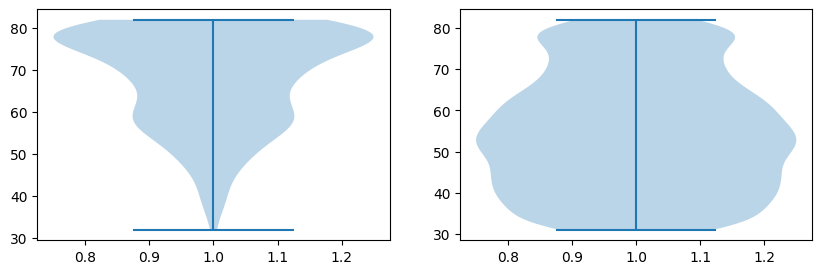

In [229]:
clean_df
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
plt.violinplot(clean_df.age[clean_df.stroke == 1])
ax2 = f.add_subplot(122)
plt.violinplot(clean_df.age[clean_df.stroke != 1])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f8c5be58be0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f8c5be49ca0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f8c5be6a1c0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f8c5be6a520>}

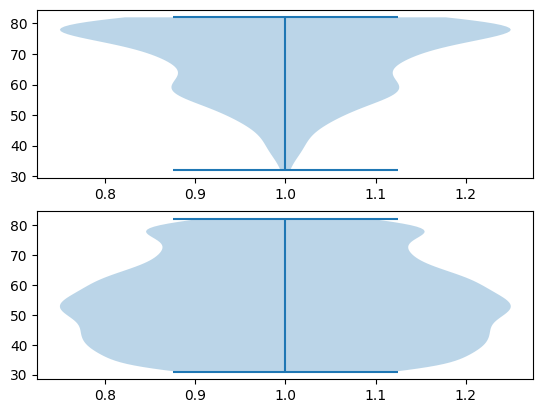

In [234]:
fig, axs = plt.subplots(2)
axs[0].violinplot(clean_df.age[clean_df.stroke == 1])
axs[1].violinplot(clean_df.age[clean_df.stroke != 1])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f8c5bc5fbb0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f8c5bc5fac0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f8c5bc71190>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f8c5bc714f0>}

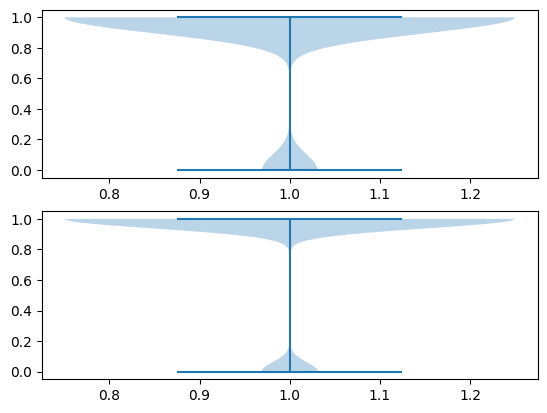

In [240]:
fig, axs = plt.subplots(2)
axs[0].violinplot(clean_df.ever_married[clean_df.stroke == 1])
axs[1].violinplot(clean_df.ever_married[clean_df.stroke != 1])

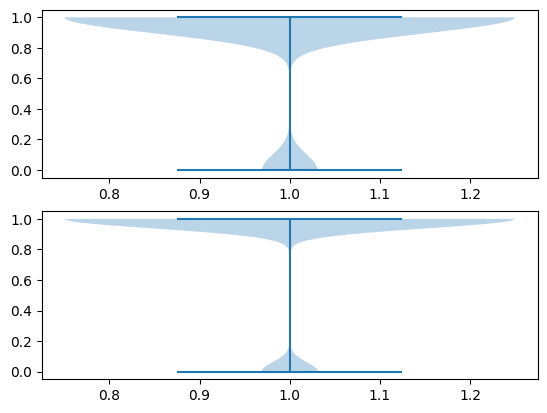

In [243]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
violin1 = axs[0].violinplot(clean_df.ever_married[clean_df.stroke == 1])
violin2 = axs[1].violinplot(clean_df.ever_married[clean_df.stroke != 1])


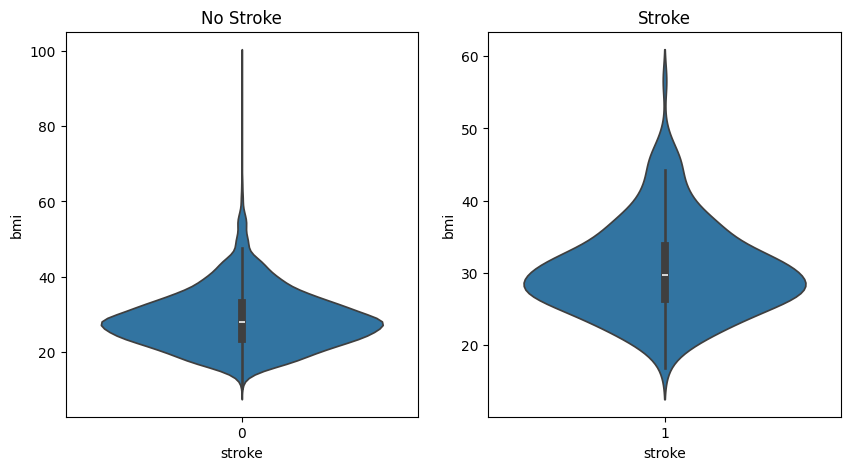

In [311]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.violinplot(x='stroke', y='bmi', data=df[df.stroke != 1].dropna(), ax=axs[0])
sns.violinplot(x='stroke', y='bmi', data=df[df.stroke == 1].dropna(), ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')

plt.show()


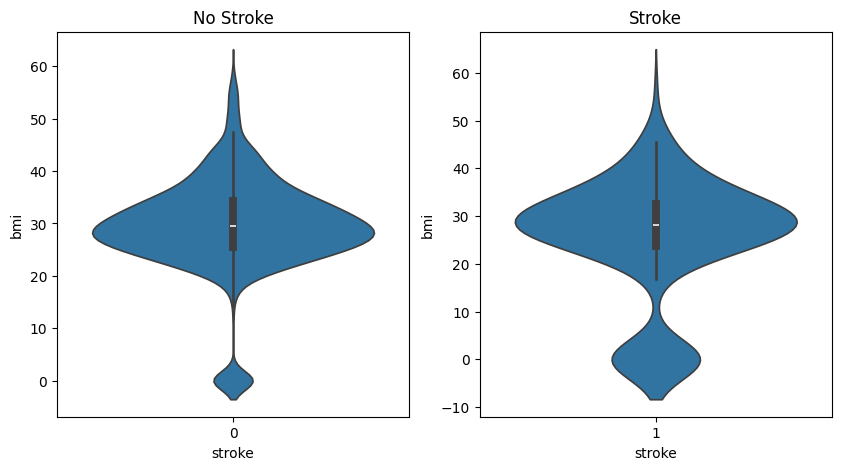

In [312]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.violinplot(x='stroke', y='bmi', data=clean_df[clean_df.stroke != 1], ax=axs[0])
sns.violinplot(x='stroke', y='bmi', data=clean_df[clean_df.stroke == 1], ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')

plt.show()


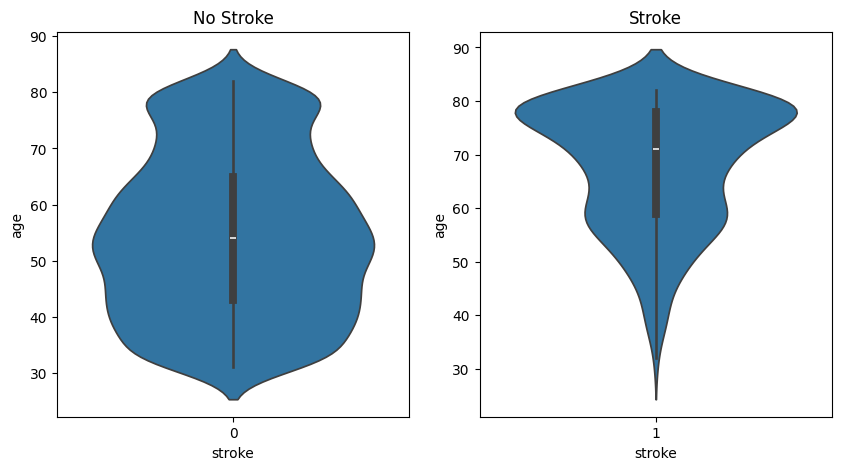

In [307]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.violinplot(x='stroke', y='age', data=clean_df[clean_df.stroke != 1], ax=axs[0])
sns.violinplot(x='stroke', y='age', data=clean_df[clean_df.stroke == 1], ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')

plt.show()


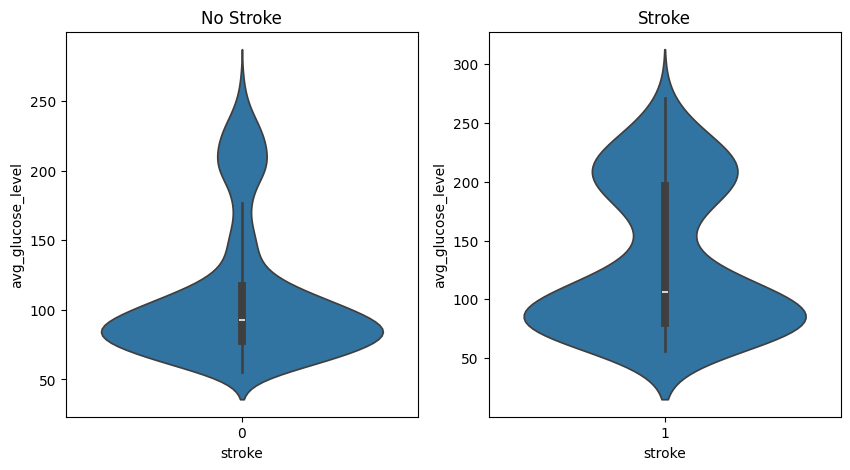

In [252]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.violinplot(x='stroke', y='avg_glucose_level', data=clean_df[clean_df.stroke != 1], ax=axs[0])
sns.violinplot(x='stroke', y='avg_glucose_level', data=clean_df[clean_df.stroke == 1], ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')

plt.show()


In [306]:
clean_df.stroke.value_counts(normalize=True)

stroke
0    0.930048
1    0.069952
Name: proportion, dtype: float64

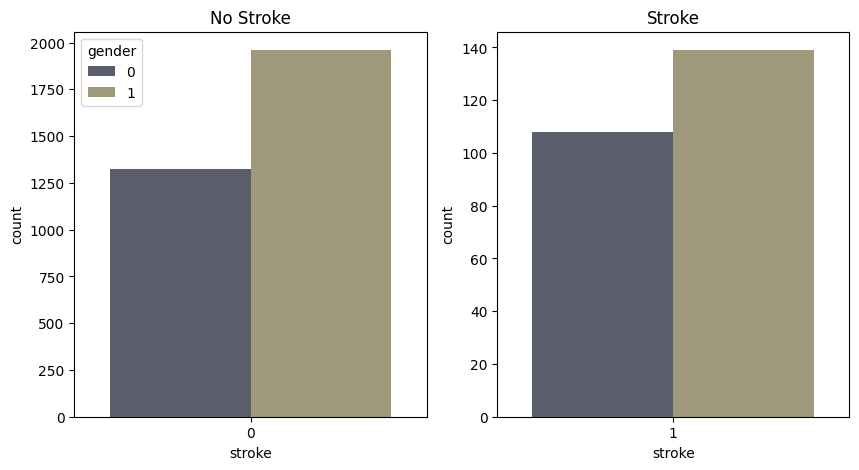

In [305]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='gender', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='gender', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


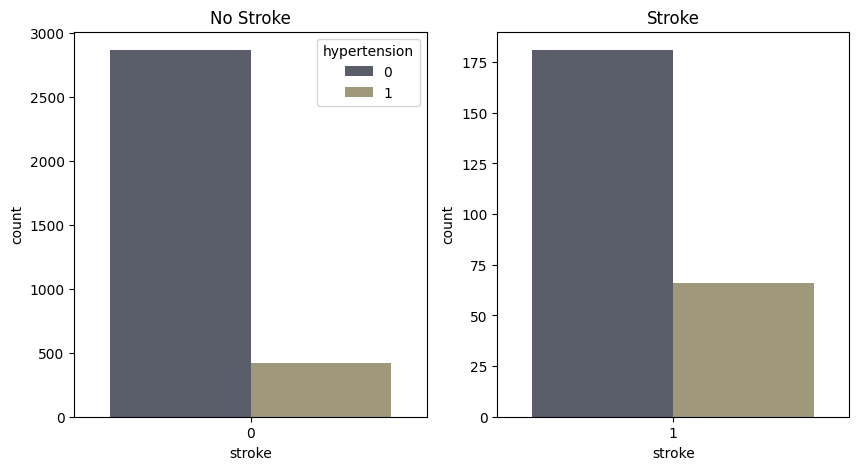

In [304]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='hypertension', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='hypertension', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


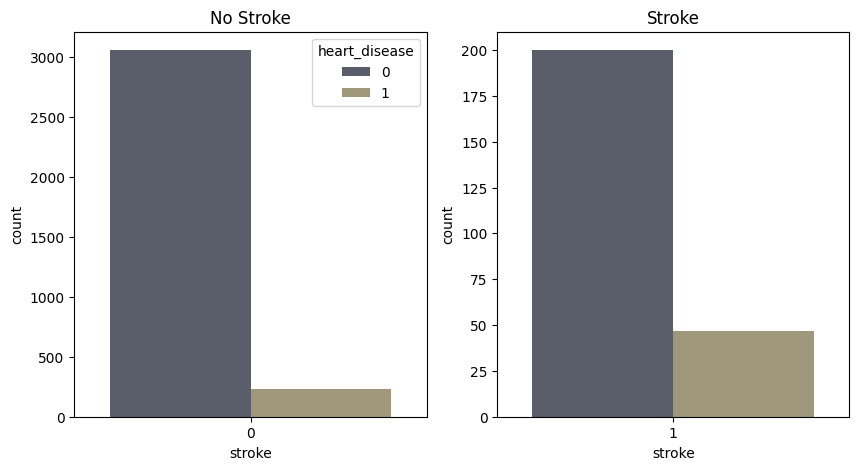

In [303]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='heart_disease', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='heart_disease', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


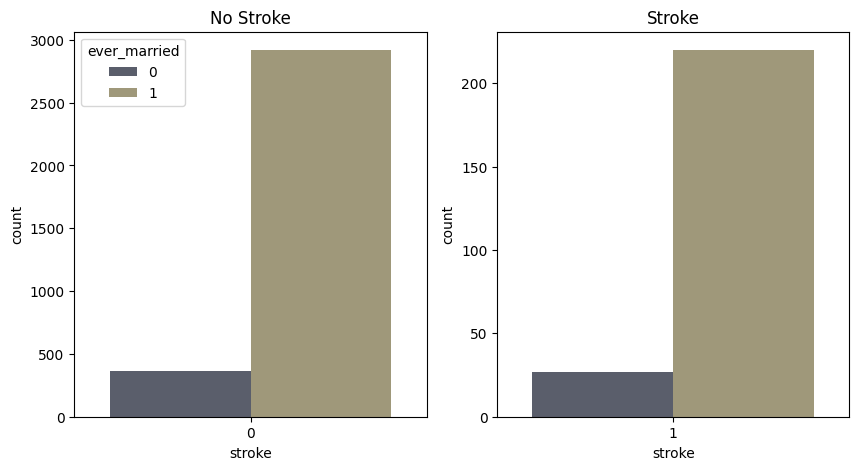

In [302]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='ever_married', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='ever_married', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


In [274]:
clean_df[clean_df.stroke !=1]['ever_married'].value_counts(normalize=True)

ever_married
1    0.888855
0    0.111145
Name: proportion, dtype: float64

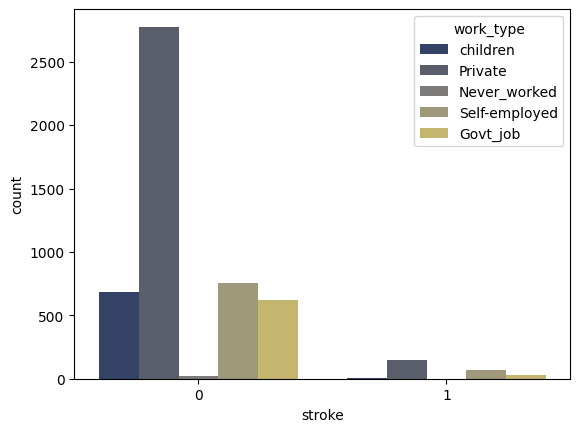

In [301]:
sns.countplot(x='stroke', hue='work_type', data=df, palette="cividis")
plt.show()

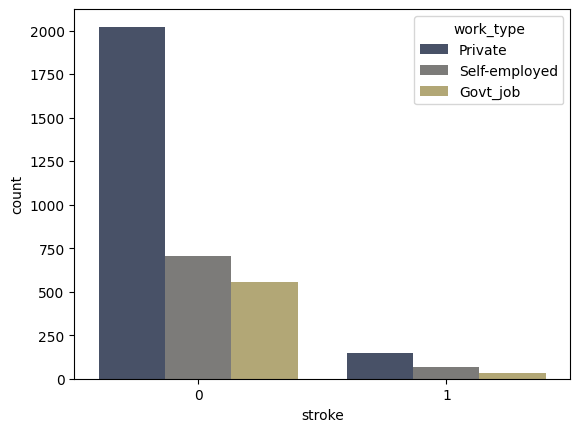

In [300]:
sns.countplot(x='stroke', hue='work_type', data=clean_df, palette='cividis')
plt.show()


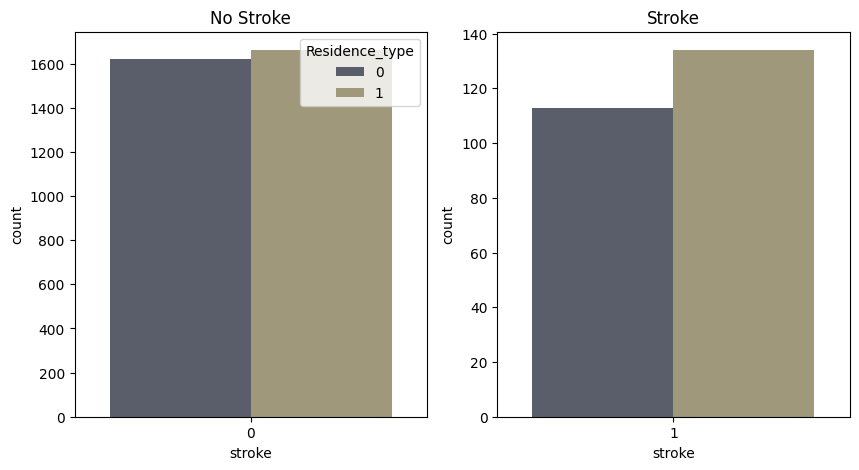

In [299]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='Residence_type', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='Residence_type', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


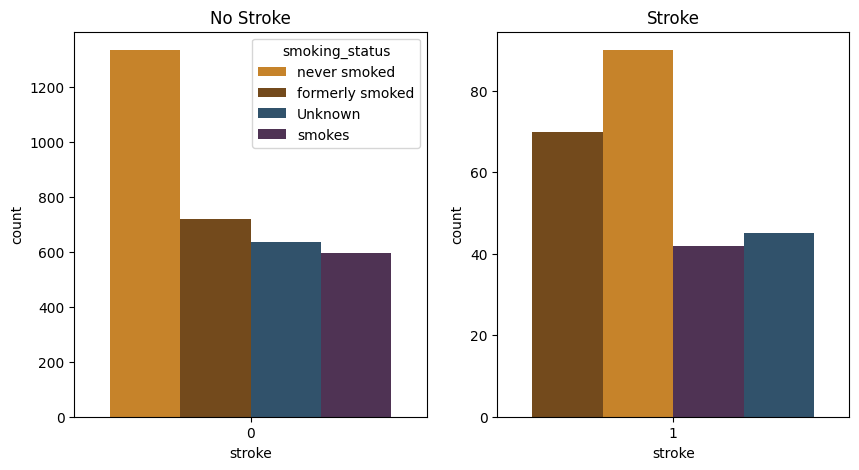

In [298]:
custom_palette = {'Unknown': '#275375', 'formerly smoked': '#824b0d', 'never smoked': '#e08610', 'smokes': '#532e59'}

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='smoking_status', data=clean_df[clean_df.stroke ==0], palette=custom_palette, ax=axs[0])
sns.countplot(x='stroke', hue='smoking_status', data=clean_df[clean_df.stroke ==1], palette=custom_palette, ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


In [294]:
clean_df[clean_df.stroke ==1].smoking_status.value_counts()

smoking_status
never smoked       90
formerly smoked    70
Unknown            45
smokes             42
Name: count, dtype: int64

In [249]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [190]:
from sklearn.svm import SVC

In [198]:
clean_df[clean_df.age<40]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
49,36338,1,39.0,1,0,1,Private,0,58.09,39.2,smokes,1
118,31720,1,38.0,0,0,0,Self-employed,1,82.28,24.0,formerly smoked,1
133,31563,1,38.0,0,0,1,Private,0,101.45,0.0,formerly smoked,1
182,39912,1,32.0,0,0,1,Private,0,76.13,29.9,smokes,1
210,33943,1,39.0,0,0,1,Private,1,83.24,26.3,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5065,7789,1,31.0,0,0,1,Private,1,89.01,37.4,never smoked,0
5066,40112,1,37.0,0,0,0,Private,1,118.41,25.1,never smoked,0
5072,71957,1,35.0,0,0,1,Private,0,58.72,40.0,smokes,0
5076,39935,1,34.0,0,0,1,Private,0,174.37,23.0,never smoked,0


id                             31720
gender                             1
age                             38.0
hypertension                       0
heart_disease                      0
ever_married                       0
work_type              Self-employed
Residence_type                     1
avg_glucose_level              82.28
bmi                             24.0
smoking_status       formerly smoked
stroke                             1
Name: 118, dtype: object

In [236]:
pd.DataFrame(clean_df.iloc[118,:]).transpose()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
118,31720,1,38.0,0,0,0,Self-employed,1,82.28,24.0,formerly smoked,1


In [196]:

to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
already_processed = ['Residence_type', 'gender']

select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', SVC(random_state=0, class_weight='balanced', probability = True, max_iter= 200, gamma='auto')) #class_weight
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)


    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))
    if recall_list[-1] == max(recall_list) :
        joblib.dump(pipeline, 'app/app_model/model.pkl')

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

/home/julienrm/.pyenv/versions/3.8.12/envs/stroke-alert/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/3.8.12/envs/stroke-alert/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/3.8.12/envs/stroke-alert/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/3.8.12/envs/stroke-alert/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScale

# Used features count : 5 - ['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']
# Mean Recall: 1.00000
# Mean r2 Test_Score: 0.06998
# Average prediction error: ~0.9644 (RMSE)
min/max recall result[1.0, 1.0]


/home/julienrm/.pyenv/versions/3.8.12/envs/stroke-alert/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/3.8.12/envs/stroke-alert/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [201]:
clean_df.iloc[118,:]

id                             31720
gender                             1
age                             38.0
hypertension                       0
heart_disease                      0
ever_married                       0
work_type              Self-employed
Residence_type                     1
avg_glucose_level              82.28
bmi                             24.0
smoking_status       formerly smoked
stroke                             1
Name: 118, dtype: object

In [209]:
# pd.DataFrame(clean_df.iloc[118,:][['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']],\
#     columns=['smoking_status', 'age', 'bmi', 'Residence_type', 'gender'])

,smoking_status,age,bmi,Residence_type,gender


In [217]:
clean_df.iloc[118,:].index

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [238]:
# should be 0 with that background

pipeline.predict(pd.DataFrame(clean_df.iloc[118,:]).transpose())


array([1])

4. Machine Learning


In [40]:
df_x = df.drop(columns ="stroke")
df_y = df['stroke']
# model = LogisticRegression()
# model.fit(df_x, df_y)
# accuracy = model.score(df_x,df_y)

In [41]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]

    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)

    # from Sacia
    clean_df = clean_df[clean_df.bmi <= 60]

    # A CHANGER ABSOLUMENT
    clean_df = clean_df.dropna(axis=0, subset='bmi')


<Axes: >

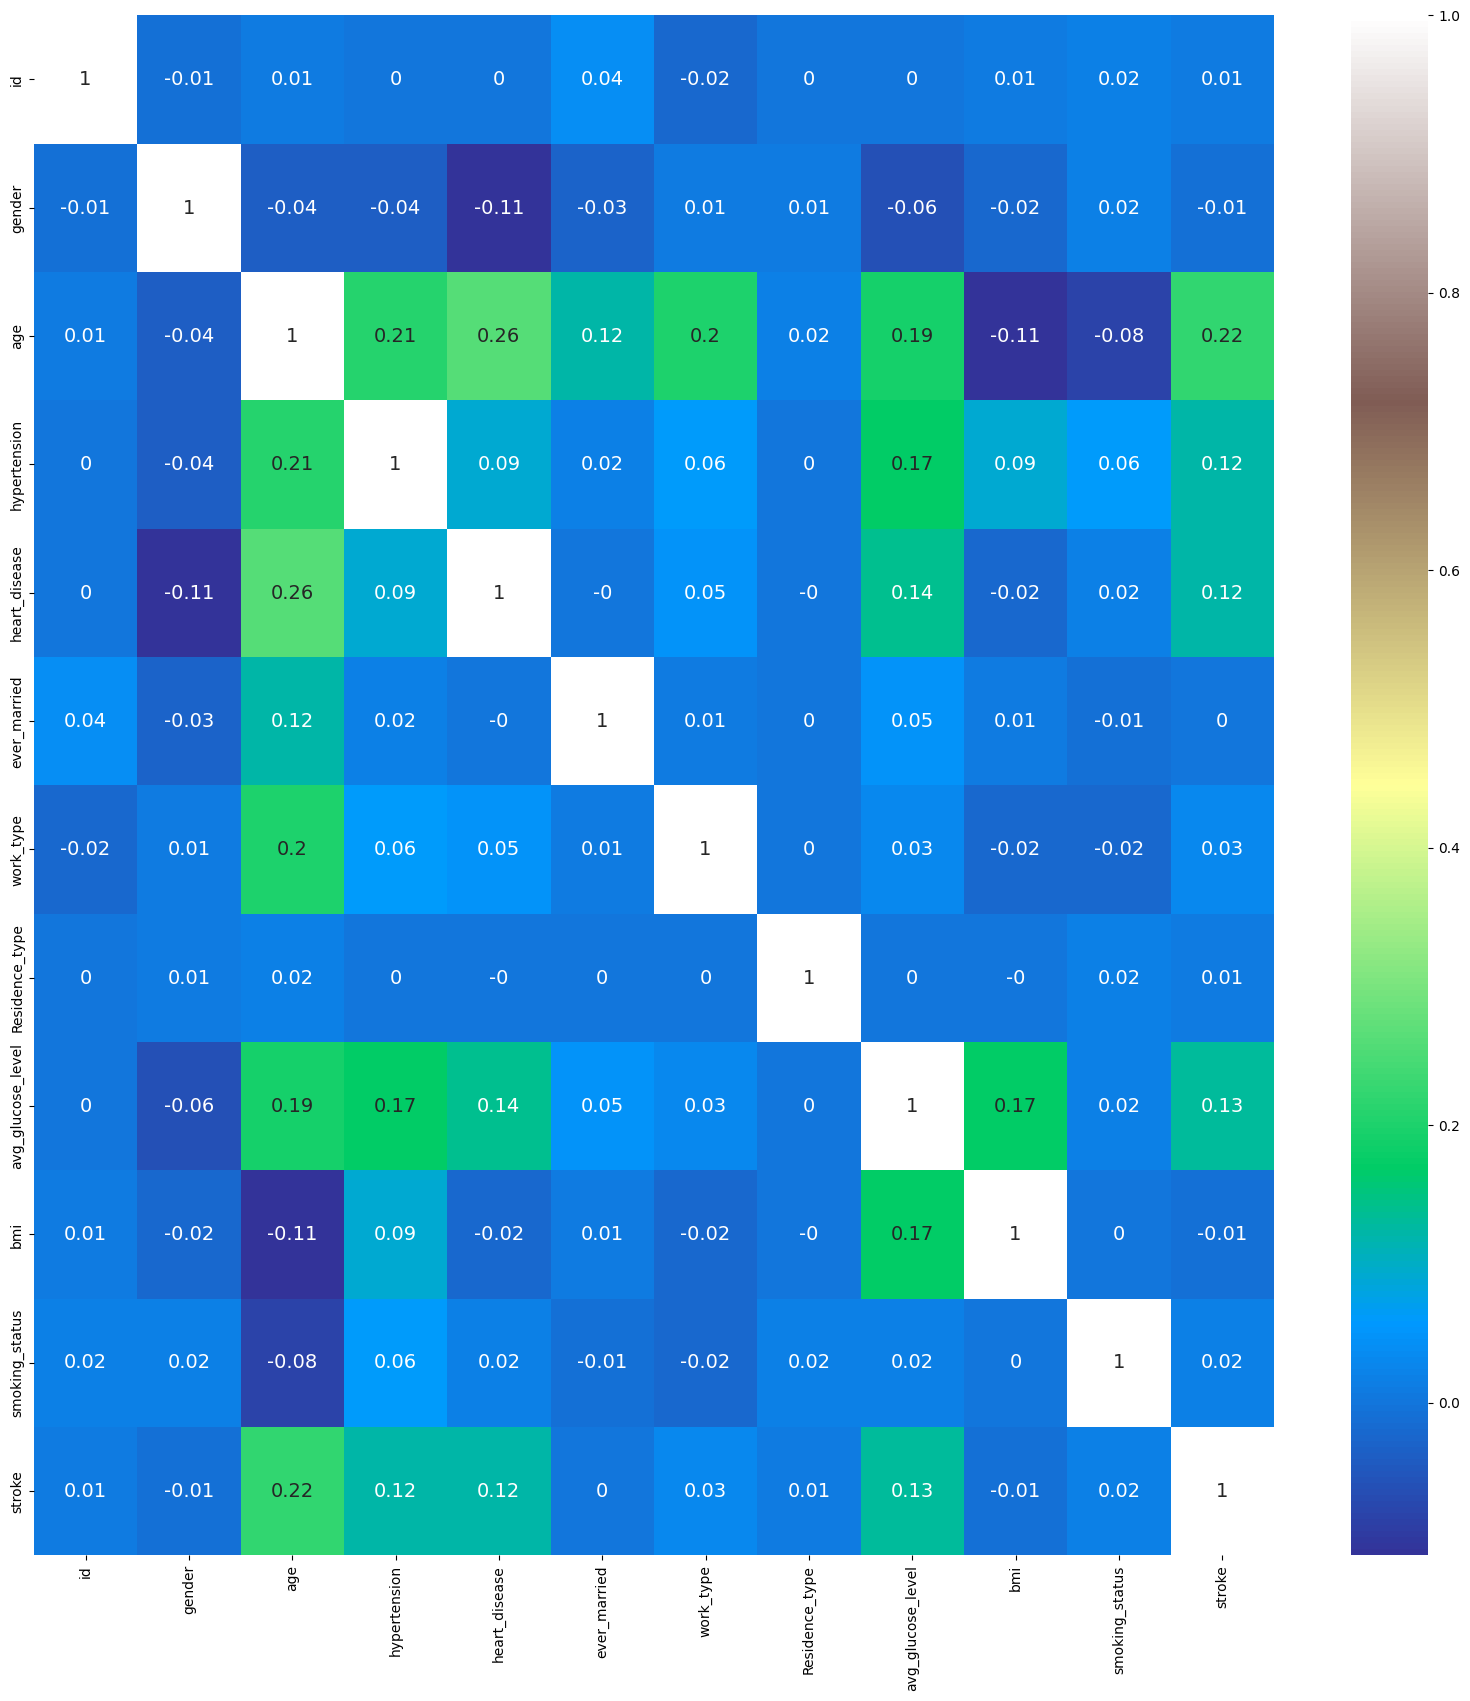

In [42]:
corr_map_df = clean_df
corr_map_df.work_type = corr_map_df['work_type'].astype('category')
corr_map_df.work_type = corr_map_df['work_type'].cat.codes

corr_map_df.smoking_status = corr_map_df['smoking_status'].astype('category')
corr_map_df.smoking_status = corr_map_df['smoking_status'].cat.codes

plt.figure(figsize = (20,20))
sns.heatmap(round(corr_map_df.corr(),2), cmap = "terrain", annot = True, annot_kws = {"size":14})
# hsv terrain jet rainbow tab10 Pastel1 Set3 RdBu viridis inferno plasma cividis magma

without class balance

In [43]:



# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['work_type', 'smoking_status' ]
to_robust = ['age', 'avg_glucose_level', 'bmi']
# to_min_max = []
already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(500):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', RobustScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', class_weight='balanced'))  # Linear Regression model
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 10
# Mean Recall: 0.71082
# Mean r2 Test_Score: 0.70177
# Average prediction error: ~0.5460 (RMSE)
min/max recall result[0.5087719298245614, 0.8709677419354839]


with undersampling

In [44]:

class_0_df = clean_df[clean_df['stroke'] == 0]
class_1_df = clean_df[clean_df['stroke'] == 1]

undersampled_class_0_data = class_0_df.sample(n=len(class_1_df), random_state=42)
clean_df = pd.concat([undersampled_class_0_data, class_1_df])
clean_df = clean_df.sample(frac=1, random_state=42)

# Now, 'undersampled_data' contains an undersampled version of your original dataset


In [56]:



# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['work_type', 'smoking_status' ]
to_robust = ['age', 'avg_glucose_level', 'bmi']
# to_min_max = []
already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(500):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', RobustScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2'))  # Linear Regression model
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 10
# Mean Recall: 0.00546
# Mean r2 Test_Score: 0.93861
# Average prediction error: ~0.2474 (RMSE)
min/max recall result[0.0, 0.05555555555555555]


With both undersampling and oversampling

In [46]:

class_0_df = clean_df[clean_df['stroke'] == 0]
class_1_df = clean_df[clean_df['stroke'] == 1]

undersampled_class_0_data = class_0_df.sample(n=len(class_1_df)*2, replace=True, random_state=42)
clean_df = pd.concat([class_1_df, undersampled_class_0_data, class_1_df])
clean_df = clean_df.sample(frac=1, random_state=42)

# Now, 'undersampled_data' contains an undersampled version of your original dataset


In [47]:



# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['work_type', 'smoking_status' ]
to_robust = ['age', 'avg_glucose_level', 'bmi']
# to_min_max = []
already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=1000, verbose = 0, n_jobs=4))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 10
# Mean Recall: 0.74219
# Mean r2 Test_Score: 0.72920
# Average prediction error: ~0.5198 (RMSE)
min/max recall result[0.6349206349206349, 0.8174603174603174]


One by One Features

In [48]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]
    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
    clean_df = clean_df.dropna(axis=0, subset='bmi')


In [49]:
# clean_df

Categorical

In [50]:
# %%writefile my_python_file.py
# All Columns to preprocess
# to_classify = ['work_type', 'smoking_status' ]
# to_robust = ['age', 'avg_glucose_level', 'bmi']
# # to_min_max = []
# already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
# select_features = ['work_type'] # + to_min_max
select_features = ['smoking_status']

X = clean_df[select_features]
y = clean_df['stroke']  # Target
r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), select_features),
        # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=100, class_weight='balanced'))  # Linear Regression model class_weight='balanced' , n_jobs=4
    ])
    # print(f"{X_train, y_train}")
    pipeline.fit(X_train, y_train)
    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1
# Mean Recall: 0.47654
# Mean r2 Test_Score: 0.54585
# Average prediction error: ~0.6629 (RMSE)
min/max recall result[0.18518518518518517, 0.8769230769230769]


First attempts :

work_type : 0.42

smoking_status : 0.49


Numericals

In [51]:

# %%writefile my_python_file.py
# All Columns to preprocess
# to_classify = ['work_type', 'smoking_status' ]
# to_robust = ['age', 'avg_glucose_level', 'bmi']
# # to_min_max = []
# already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
# select_features = ['work_type'] # + to_min_max
select_features = ['bmi']

X = clean_df[select_features]
y = clean_df['stroke']  # Target
r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', MinMaxScaler(), select_features),
        # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=100, class_weight='balanced'))  # Linear Regression model class_weight='balanced' , n_jobs=4
    ])
    # print(f"{X_train, y_train}")
    pipeline.fit(X_train, y_train)
    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1
# Mean Recall: 0.53138
# Mean r2 Test_Score: 0.46182
# Average prediction error: ~0.7332 (RMSE)
min/max recall result[0.2537313432835821, 0.6491228070175439]


First attempts :

age : 0.67

avg_glucose_level : 0.42

bmi : 0.55574


Binaries

In [52]:
# %%writefile my_python_file.py
# All Columns to preprocess
# to_classify = ['work_type', 'smoking_status' ]
# to_robust = ['age', 'avg_glucose_level', 'bmi']
# # to_min_max = []
# already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
# select_features = ['work_type'] # + to_min_max
select_features = ['Residence_type']

X = clean_df[select_features]
y = clean_df['stroke']  # Target
r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), select_features),
        # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=100, class_weight='balanced'))  # Linear Regression model class_weight='balanced' , n_jobs=4
    ])
    # print(f"{X_train, y_train}")
    pipeline.fit(X_train, y_train)
    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1
# Mean Recall: 0.48088
# Mean r2 Test_Score: 0.49431
# Average prediction error: ~0.7111 (RMSE)
min/max recall result[0.38181818181818183, 0.5714285714285714]


First attempts :

gender : 0.42

hypertension : 0.28

heart_disease : 0.19

ever_married : 0.42845

Residence_type : 0.49


work_type : 0.42

smoking_status : 0.49





age : 0.67

avg_glucose_level : 0.42

bmi : 0.55574




gender : 0.42

hypertension : 0.28

heart_disease : 0.19

ever_married : 0.42845

Residence_type : 0.49

In [53]:
features_to_keep = ['age', 'bmi', 'smoking_status', 'Residence_type']


Regression with proper features

In [54]:
# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
# to_min_max = []
already_processed = ['Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 4 - ['smoking_status', 'age', 'bmi', 'Residence_type']
# Mean Recall: 0.71772
# Mean r2 Test_Score: 0.68858
# Average prediction error: ~0.5579 (RMSE)
min/max recall result[0.6, 0.8166666666666667]


In [55]:
# %%writefile my_python_file.py
# All Columns to preprocess
to_robust = ['age', 'bmi']
# to_min_max = []
# Bench : 'MiscFeature'
select_features = to_robust # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('robust_scaler', MinMaxScaler(), to_robust) # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 2 - ['age', 'bmi']
# Mean Recall: 0.70349
# Mean r2 Test_Score: 0.67949
# Average prediction error: ~0.5660 (RMSE)
min/max recall result[0.5892857142857143, 0.8448275862068966]


# RandomForestClassifier

In [73]:
from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification
# X, y = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                            random_state=0, shuffle=False)



# clf = RandomForestClassifier(max_depth=2, random_state=0)
# clf.fit(X, y)
# print(clf.predict([[0, 0, 0, 0]]))


[1]


In [93]:

to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
already_processed = ['Residence_type']

select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', RandomForestClassifier(max_depth=1, n_estimators=1000, random_state=0, class_weight='balanced'))
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 4 - ['smoking_status', 'age', 'bmi', 'Residence_type']
# Mean Recall: 0.70671
# Mean r2 Test_Score: 0.65277
# Average prediction error: ~0.5874 (RMSE)
min/max recall result[0.5272727272727272, 0.875]


In [182]:
from sklearn.tree import DecisionTreeClassifier
import joblib


In [167]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]
    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
    # clean_df.bmi = clean_df.bmi.apply(lambda x : x if isinstance(x, float) else 0)
    clean_df.bmi.fillna(0, inplace=True)
    clean_df = clean_df[clean_df.bmi <= 60]


In [188]:

to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
already_processed = ['Residence_type', 'gender']

select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', DecisionTreeClassifier(max_depth=2, random_state=0, class_weight='balanced')) #class_weight
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)


    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))
    if recall_list[-1] == max(recall_list) :
        joblib.dump(pipeline, 'app/app_model/model.pkl')

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 5 - ['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']
# Mean Recall: 0.79370
# Mean r2 Test_Score: 0.60591
# Average prediction error: ~0.6249 (RMSE)
min/max recall result[0.4117647058823529, 0.9487179487179487]


In [319]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]
    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
    # clean_df.bmi = clean_df.bmi.apply(lambda x : x if isinstance(x, float) else 0)
    clean_df = clean_df[clean_df.bmi <= 60]


In [314]:
from sklearn.neighbors import KNeighborsClassifier

In [325]:

to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
already_processed = ['Residence_type', 'gender']

select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', KNeighborsClassifier(n_neighbors = 20, algorithm='kd_tree')) #class_weight
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)


    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))
    if recall_list[-1] == max(recall_list) :
        joblib.dump(pipeline, 'app/app_model/model.pkl')

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")

print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 5 - ['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']
# Mean Recall: 0.00000
# Mean r2 Test_Score: 0.94178
# Average prediction error: ~0.2411 (RMSE)
min/max recall result[0.0, 0.0]


1. Imports

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# %load_ext autoreload
#%autoreload 2

# import re

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler

from sklearn.linear_model import LinearRegression, LogisticRegression


from sklearn.metrics import mean_squared_error
from sklearn.metrics import recall_score

import joblib

In [ ]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [ ]:
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df.ever_married.value_counts()

ever_married
Yes    3353
No     1757
Name: count, dtype: int64

In [ ]:
df.gender.value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

2. Data Analysis

In [ ]:
df.describe().applymap(lambda x: round(x, 3))

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000,5110.000,5110.000,5110.000,5110.000,4909.000,5110.000
mean,36517.829,43.227,0.097,0.054,106.148,28.893,0.049
std,21161.722,22.613,0.297,0.226,45.284,7.854,0.215
min,67.000,0.080,0.000,0.000,55.120,10.300,0.000
25%,17741.250,25.000,0.000,0.000,77.245,23.500,0.000
50%,36932.000,45.000,0.000,0.000,91.885,28.100,0.000
75%,54682.000,61.000,0.000,0.000,114.090,33.100,0.000
max,72940.000,82.000,1.000,1.000,271.740,97.600,1.000


In [ ]:
# plt.figure(figsize = (50,50))
# sns.heatmap(round(df.corr(),2), cmap = "coolwarm", annot = True, annot_kws = {"size":12})

In [ ]:
# plt.figure(figsize=(15,4))

# sns.regplot(x='age', y='stroke', data=df.sample(100, random_state=9), ci=95)

In [ ]:
df.nunique()[df.nunique() == 2]

hypertension      2
heart_disease     2
ever_married      2
Residence_type    2
stroke            2
dtype: int64

In [ ]:
df.drop(columns=['id']).nunique()[df.nunique() != 2]

gender                  3
age                   104
work_type               5
avg_glucose_level    3979
bmi                   418
smoking_status          4
dtype: int64

In [ ]:
# Display numerics columns
df.select_dtypes(include=['int64', 'float64'])

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,9046,67.0,0,1,228.69,36.6,1
1,51676,61.0,0,0,202.21,NaN,1
2,31112,80.0,0,1,105.92,32.5,1
3,60182,49.0,0,0,171.23,34.4,1
4,1665,79.0,1,0,174.12,24.0,1
...,...,...,...,...,...,...,...
5105,18234,80.0,1,0,83.75,NaN,0
5106,44873,81.0,0,0,125.20,40.0,0
5107,19723,35.0,0,0,82.99,30.6,0
5108,37544,51.0,0,0,166.29,25.6,0


In [ ]:
# Display Objects columns
df.select_dtypes(include=['O'])

,gender,ever_married,work_type,Residence_type,smoking_status
0,Male,Yes,Private,Urban,formerly smoked
1,Female,Yes,Self-employed,Rural,never smoked
2,Male,Yes,Private,Rural,never smoked
3,Female,Yes,Private,Urban,smokes
4,Female,Yes,Self-employed,Rural,never smoked
...,...,...,...,...,...
5105,Female,Yes,Private,Urban,never smoked
5106,Female,Yes,Self-employed,Urban,never smoked
5107,Female,Yes,Self-employed,Rural,never smoked
5108,Male,Yes,Private,Rural,formerly smoked


In [ ]:
# curves_step = [1, 200, 300, 400, 500, 600, 650, 712]
# train_sizes, train_scores, test_scores = learning_curve(
#     estimator=LogisticRegression(), X=X, y=y, train_sizes=curves_step, cv=5)
# train_scores_mean = np.mean(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# plt.plot(train_sizes, train_scores_mean, label = 'Training score')
# plt.plot(train_sizes, test_scores_mean, label = 'Test score')
# plt.ylabel('r2 score', fontsize = 14)
# plt.xlabel('Training set size', fontsize = 14)
# plt.title('Learning curves', fontsize = 18, y = 1.03)
# plt.legend()

In [ ]:
# df.shape
# df.isna()
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values(ascending=False).head(15)


bmi                  3.933464
id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
smoking_status       0.000000
stroke               0.000000
dtype: float64

In [ ]:
# df.gender.value_counts()
df.age.min()


0.08

In [ ]:
df.age.count()

5110

En outlier sur la colonne age on à un avc recensé à 2 ans et un autre à 16 ans 

In [ ]:
df[df.age<30].stroke.value_counts()

stroke
0    1513
1       2
Name: count, dtype: int64

In [ ]:
df[df.age<39].stroke.value_counts()

stroke
0    2094
1       5
Name: count, dtype: int64

In [ ]:
# sns.histplot(x=df.stroke, y=df.age) with stroke in hue
# sns.histplot(df.age.value_counts, df.age.value_counts.index)

In [ ]:
df.avg_glucose_level.min()


55.12

In [ ]:
df.avg_glucose_level.max()

271.74

In [ ]:
df.bmi.isna().value_counts()

bmi
False    4909
True      201
Name: count, dtype: int64

In [ ]:
df.smoking_status.value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

In [ ]:
df.stroke.value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

In [ ]:
df.work_type

0             Private
1       Self-employed
2             Private
3             Private
4       Self-employed
            ...      
5105          Private
5106    Self-employed
5107    Self-employed
5108          Private
5109         Govt_job
Name: work_type, Length: 5110, dtype: object

3. Feature Engineering

In [ ]:
clean_df = df[df.gender != 'Other']
# on va en discuter tkt
clean_df = clean_df[clean_df.age>30]

In [ ]:
df.gender.value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [ ]:
df.ever_married = df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)


In [ ]:
df.Residence_type.value_counts()
df.Residence_type = df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
df.Residence_type.value_counts()


Residence_type
1    2596
0    2514
Name: count, dtype: int64

In [ ]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,1,Self-employed,0,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,1,Private,1,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,1,Self-employed,1,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,1,Self-employed,0,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,1,Private,0,166.29,25.6,formerly smoked,0


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit_transform(df.work_type)


array([2, 3, 2, ..., 3, 2, 0])

In [ ]:
from sklearn.preprocessing import OneHotEncoder

categorical_column_reshaped = df.work_type.values.reshape(-1, 1)

OneHotEncoder(sparse_output=False).fit_transform(categorical_column_reshaped)

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [ ]:
df.work_type[0:20]

0           Private
1     Self-employed
2           Private
3           Private
4     Self-employed
5           Private
6           Private
7           Private
8           Private
9           Private
10          Private
11         Govt_job
12          Private
13          Private
14          Private
15    Self-employed
16          Private
17          Private
18          Private
19         Govt_job
Name: work_type, dtype: object

In [ ]:
encoded_columns[0:20]

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [ ]:
df.work_type.value_counts()

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

In [ ]:

# CentralAir_encoder = OneHotEncoder(sparse=False, drop='if_binary', categories=[['Private', 'Self-employed', 'children', 'Govt_job', 'Never_worked' ]]) # Instanciate encoder
# df['CentralAir'] = CentralAir_encoder.fit_transform(df.work_type) # Fit encoder and tranform

In [ ]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]
    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
    # clean_df.bmi = clean_df.bmi.apply(lambda x : x if isinstance(x, float) else 0)
    clean_df.bmi.fillna(0, inplace=True)
    clean_df = clean_df[clean_df.bmi <= 60]


{'bodies': [<matplotlib.collections.PolyCollection at 0x7f8c682dcd30>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f8c682dcbe0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f8c682cf970>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f8c682ed550>}

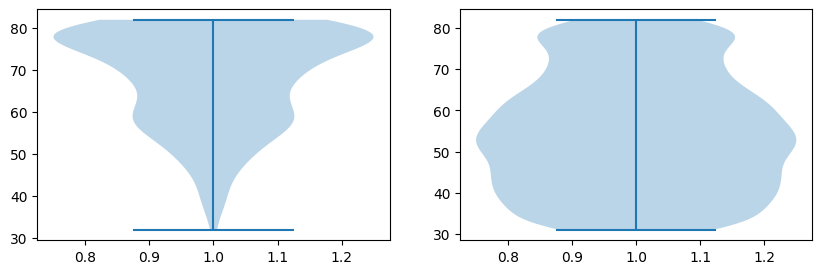

In [ ]:
clean_df
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
plt.violinplot(clean_df.age[clean_df.stroke == 1])
ax2 = f.add_subplot(122)
plt.violinplot(clean_df.age[clean_df.stroke != 1])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f8c5be58be0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f8c5be49ca0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f8c5be6a1c0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f8c5be6a520>}

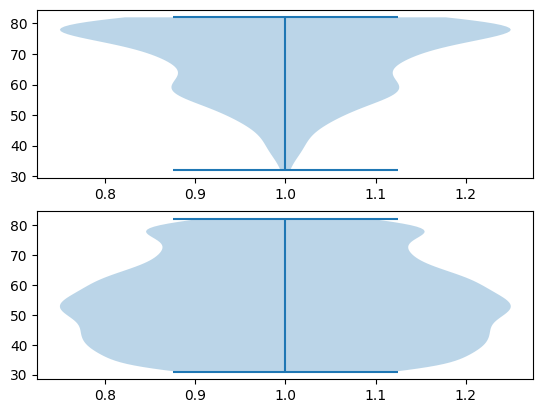

In [ ]:
fig, axs = plt.subplots(2)
axs[0].violinplot(clean_df.age[clean_df.stroke == 1])
axs[1].violinplot(clean_df.age[clean_df.stroke != 1])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f8c5bc5fbb0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f8c5bc5fac0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f8c5bc71190>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f8c5bc714f0>}

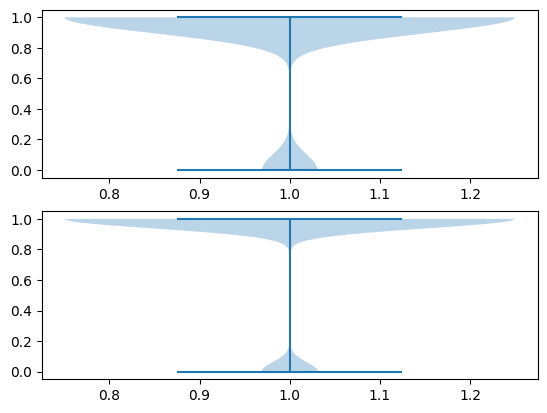

In [ ]:
fig, axs = plt.subplots(2)
axs[0].violinplot(clean_df.ever_married[clean_df.stroke == 1])
axs[1].violinplot(clean_df.ever_married[clean_df.stroke != 1])

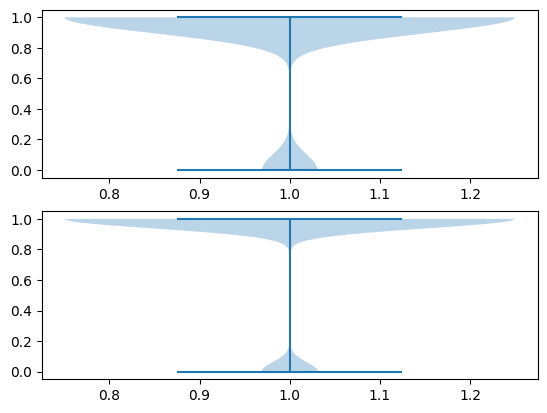

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
violin1 = axs[0].violinplot(clean_df.ever_married[clean_df.stroke == 1])
violin2 = axs[1].violinplot(clean_df.ever_married[clean_df.stroke != 1])


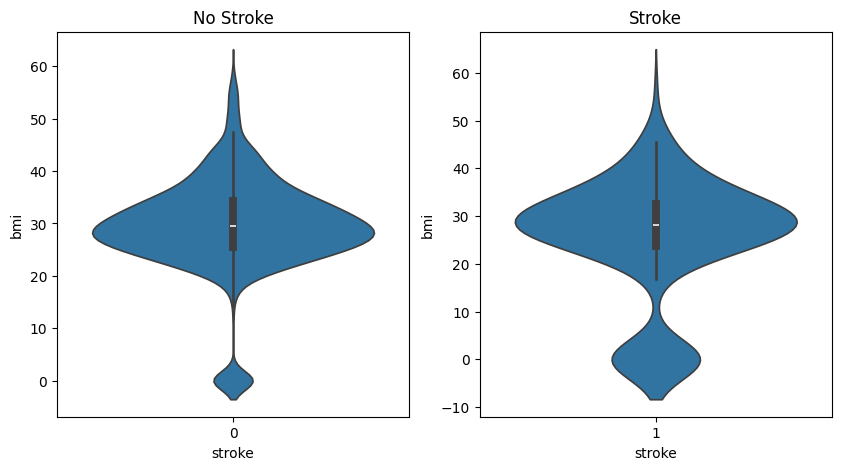

In [ ]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.violinplot(x='stroke', y='bmi', data=clean_df[clean_df.stroke != 1], ax=axs[0])
sns.violinplot(x='stroke', y='bmi', data=clean_df[clean_df.stroke == 1], ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')

plt.show()


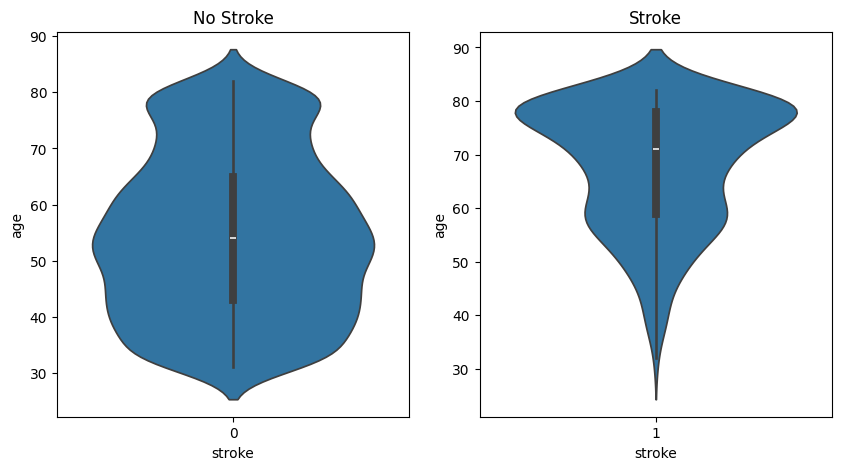

In [ ]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.violinplot(x='stroke', y='age', data=clean_df[clean_df.stroke != 1], ax=axs[0])
sns.violinplot(x='stroke', y='age', data=clean_df[clean_df.stroke == 1], ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')

plt.show()


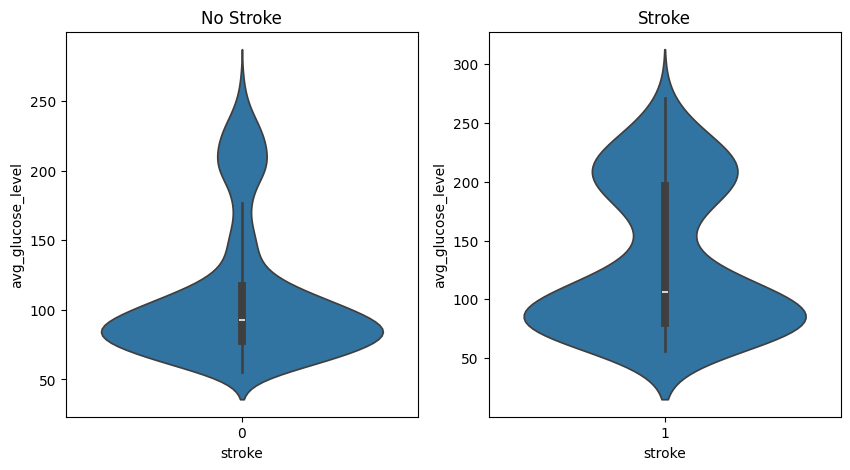

In [ ]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.violinplot(x='stroke', y='avg_glucose_level', data=clean_df[clean_df.stroke != 1], ax=axs[0])
sns.violinplot(x='stroke', y='avg_glucose_level', data=clean_df[clean_df.stroke == 1], ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')

plt.show()


In [ ]:
clean_df.stroke.value_counts(normalize=True)

stroke
0    0.930048
1    0.069952
Name: proportion, dtype: float64

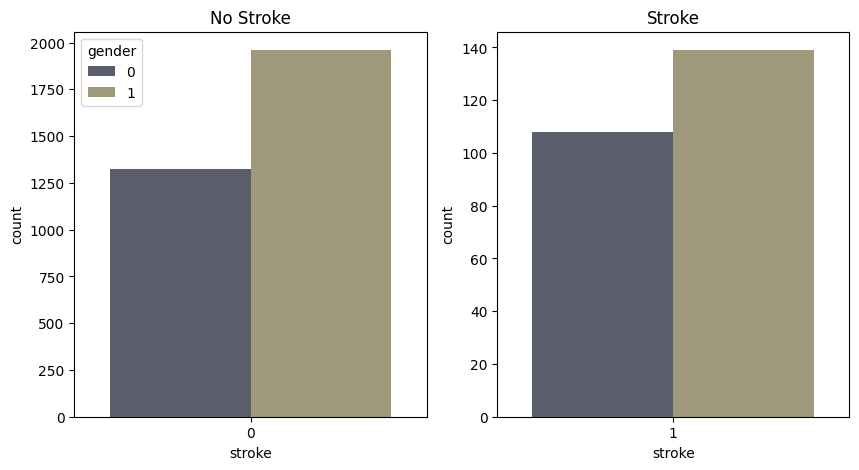

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='gender', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='gender', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


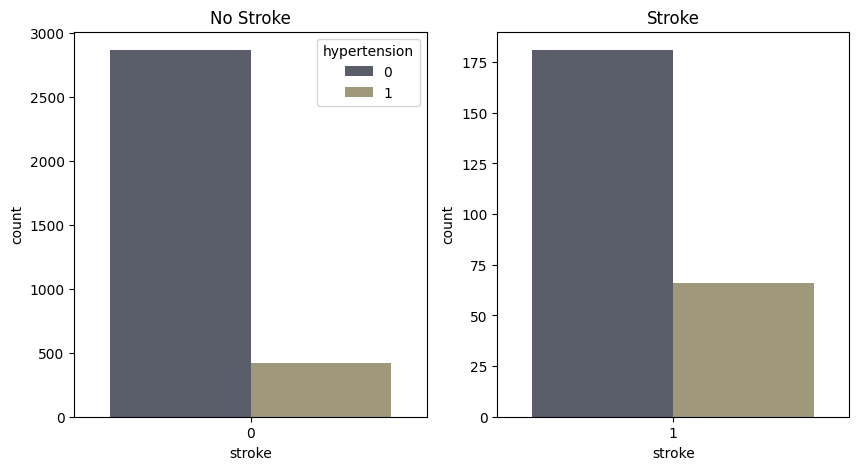

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='hypertension', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='hypertension', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


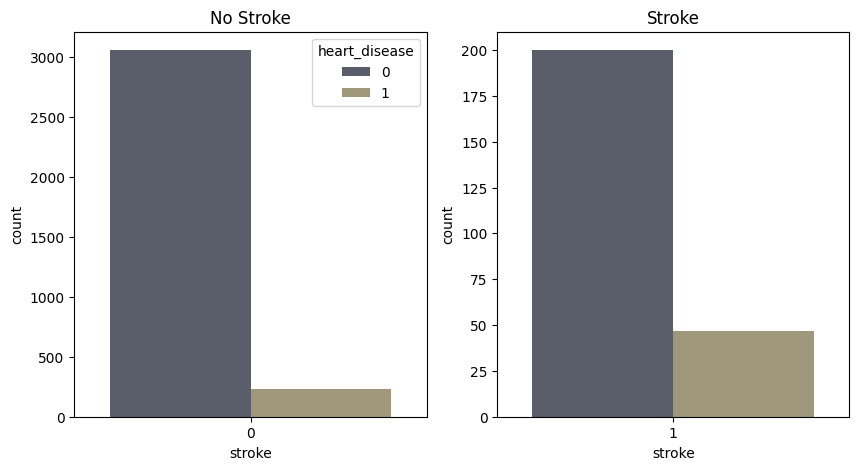

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='heart_disease', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='heart_disease', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


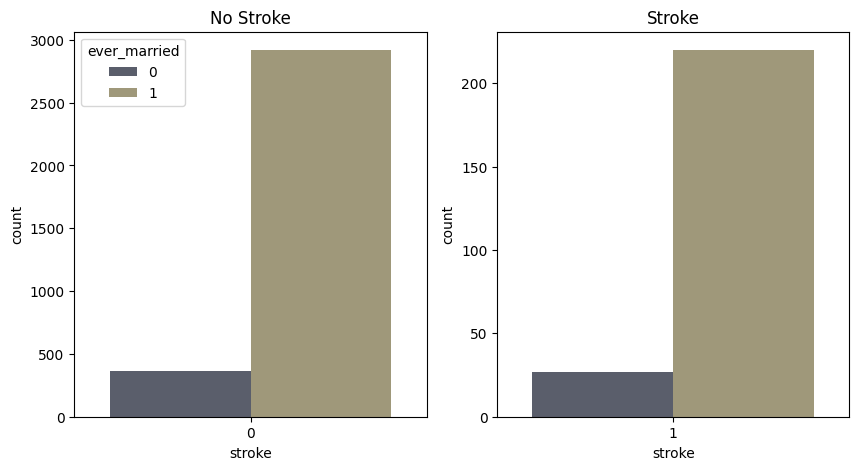

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='ever_married', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='ever_married', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


In [ ]:
clean_df[clean_df.stroke !=1]['ever_married'].value_counts(normalize=True)

ever_married
1    0.888855
0    0.111145
Name: proportion, dtype: float64

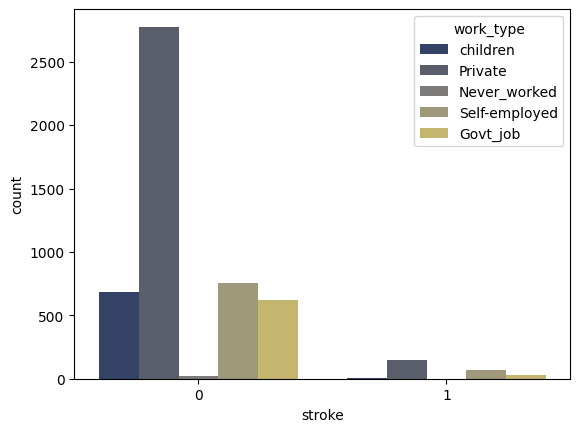

In [ ]:
sns.countplot(x='stroke', hue='work_type', data=df, palette="cividis")
plt.show()

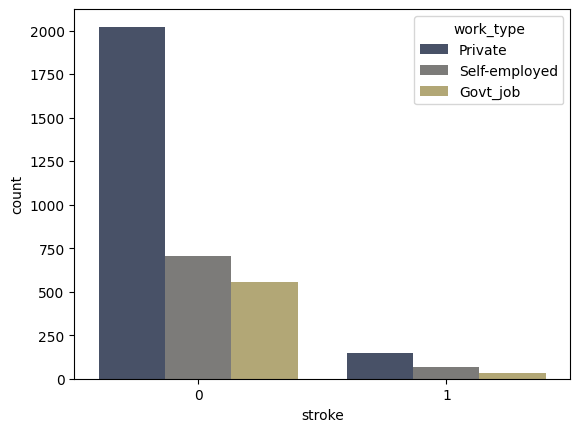

In [ ]:
sns.countplot(x='stroke', hue='work_type', data=clean_df, palette='cividis')
plt.show()


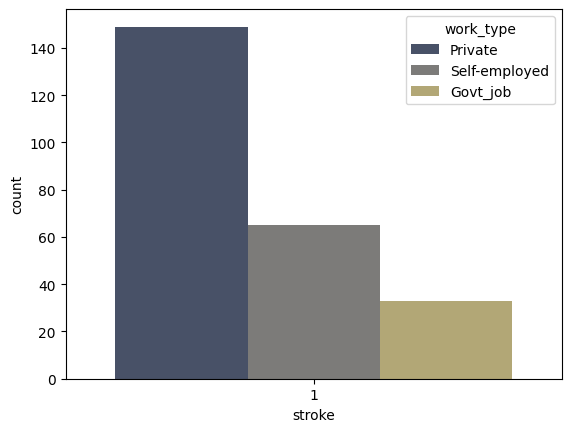

In [ ]:
sns.countplot(x='stroke', hue='work_type', data=clean_df[clean_df.stroke ==1], palette="cividis")
plt.show()

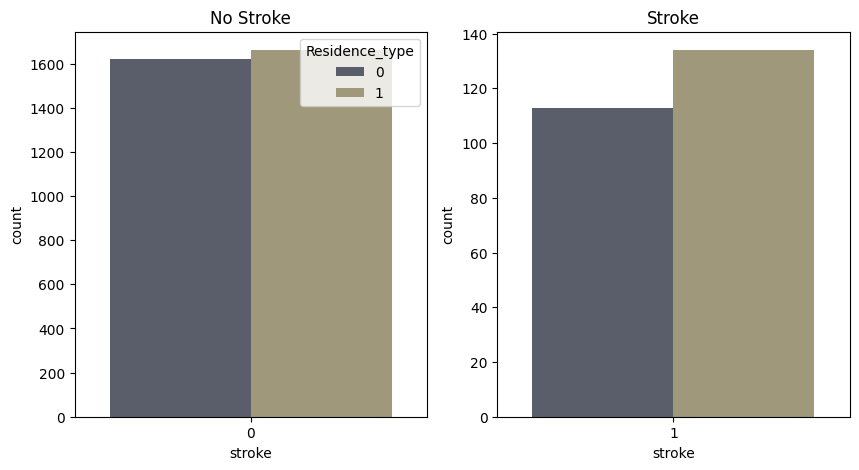

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='stroke', hue='Residence_type', data=clean_df[clean_df.stroke ==0], palette='cividis', ax=axs[0])
sns.countplot(x='stroke', hue='Residence_type', data=clean_df[clean_df.stroke ==1], palette='cividis', ax=axs[1])

axs[0].set_title('No Stroke')
axs[1].set_title('Stroke')
axs[1].legend_.remove()

plt.show()


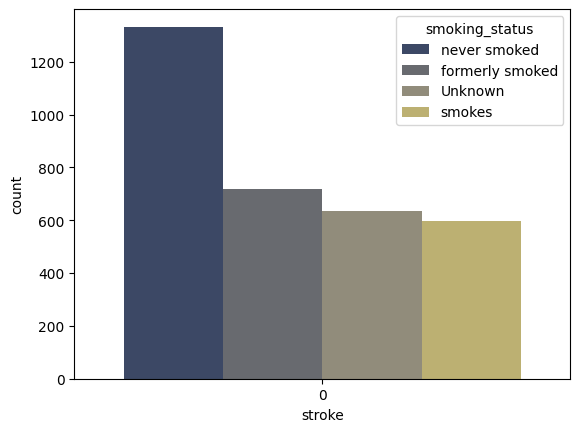

In [ ]:

plt.show()

In [ ]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [ ]:
from sklearn.svm import SVC

In [ ]:
clean_df[clean_df.age<40]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
49,36338,1,39.0,1,0,1,Private,0,58.09,39.2,smokes,1
118,31720,1,38.0,0,0,0,Self-employed,1,82.28,24.0,formerly smoked,1
133,31563,1,38.0,0,0,1,Private,0,101.45,0.0,formerly smoked,1
182,39912,1,32.0,0,0,1,Private,0,76.13,29.9,smokes,1
210,33943,1,39.0,0,0,1,Private,1,83.24,26.3,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5065,7789,1,31.0,0,0,1,Private,1,89.01,37.4,never smoked,0
5066,40112,1,37.0,0,0,0,Private,1,118.41,25.1,never smoked,0
5072,71957,1,35.0,0,0,1,Private,0,58.72,40.0,smokes,0
5076,39935,1,34.0,0,0,1,Private,0,174.37,23.0,never smoked,0


id                             31720
gender                             1
age                             38.0
hypertension                       0
heart_disease                      0
ever_married                       0
work_type              Self-employed
Residence_type                     1
avg_glucose_level              82.28
bmi                             24.0
smoking_status       formerly smoked
stroke                             1
Name: 118, dtype: object

In [ ]:
pd.DataFrame(clean_df.iloc[118,:]).transpose()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
118,31720,1,38.0,0,0,0,Self-employed,1,82.28,24.0,formerly smoked,1


In [ ]:

to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
already_processed = ['Residence_type', 'gender']

select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', SVC(random_state=0, class_weight='balanced', probability = True, max_iter= 200, gamma='auto')) #class_weight
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)


    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))
    if recall_list[-1] == max(recall_list) :
        joblib.dump(pipeline, 'app/app_model/model.pkl')

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

/home/julienrm/.pyenv/versions/3.8.12/envs/stroke-alert/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/3.8.12/envs/stroke-alert/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/3.8.12/envs/stroke-alert/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/3.8.12/envs/stroke-alert/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScale

# Used features count : 5 - ['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']
# Mean Recall: 1.00000
# Mean r2 Test_Score: 0.06998
# Average prediction error: ~0.9644 (RMSE)
min/max recall result[1.0, 1.0]


/home/julienrm/.pyenv/versions/3.8.12/envs/stroke-alert/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/julienrm/.pyenv/versions/3.8.12/envs/stroke-alert/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [ ]:
clean_df.iloc[118,:]

id                             31720
gender                             1
age                             38.0
hypertension                       0
heart_disease                      0
ever_married                       0
work_type              Self-employed
Residence_type                     1
avg_glucose_level              82.28
bmi                             24.0
smoking_status       formerly smoked
stroke                             1
Name: 118, dtype: object

In [ ]:
# pd.DataFrame(clean_df.iloc[118,:][['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']],\
#     columns=['smoking_status', 'age', 'bmi', 'Residence_type', 'gender'])

,smoking_status,age,bmi,Residence_type,gender


In [ ]:
clean_df.iloc[118,:].index

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [ ]:
# should be 0 with that background

pipeline.predict(pd.DataFrame(clean_df.iloc[118,:]).transpose())


array([1])

4. Machine Learning


In [ ]:
df_x = df.drop(columns ="stroke")
df_y = df['stroke']
# model = LogisticRegression()
# model.fit(df_x, df_y)
# accuracy = model.score(df_x,df_y)

In [ ]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]

    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)

    # from Sacia
    clean_df = clean_df[clean_df.bmi <= 60]

    # A CHANGER ABSOLUMENT
    clean_df = clean_df.dropna(axis=0, subset='bmi')


<Axes: >

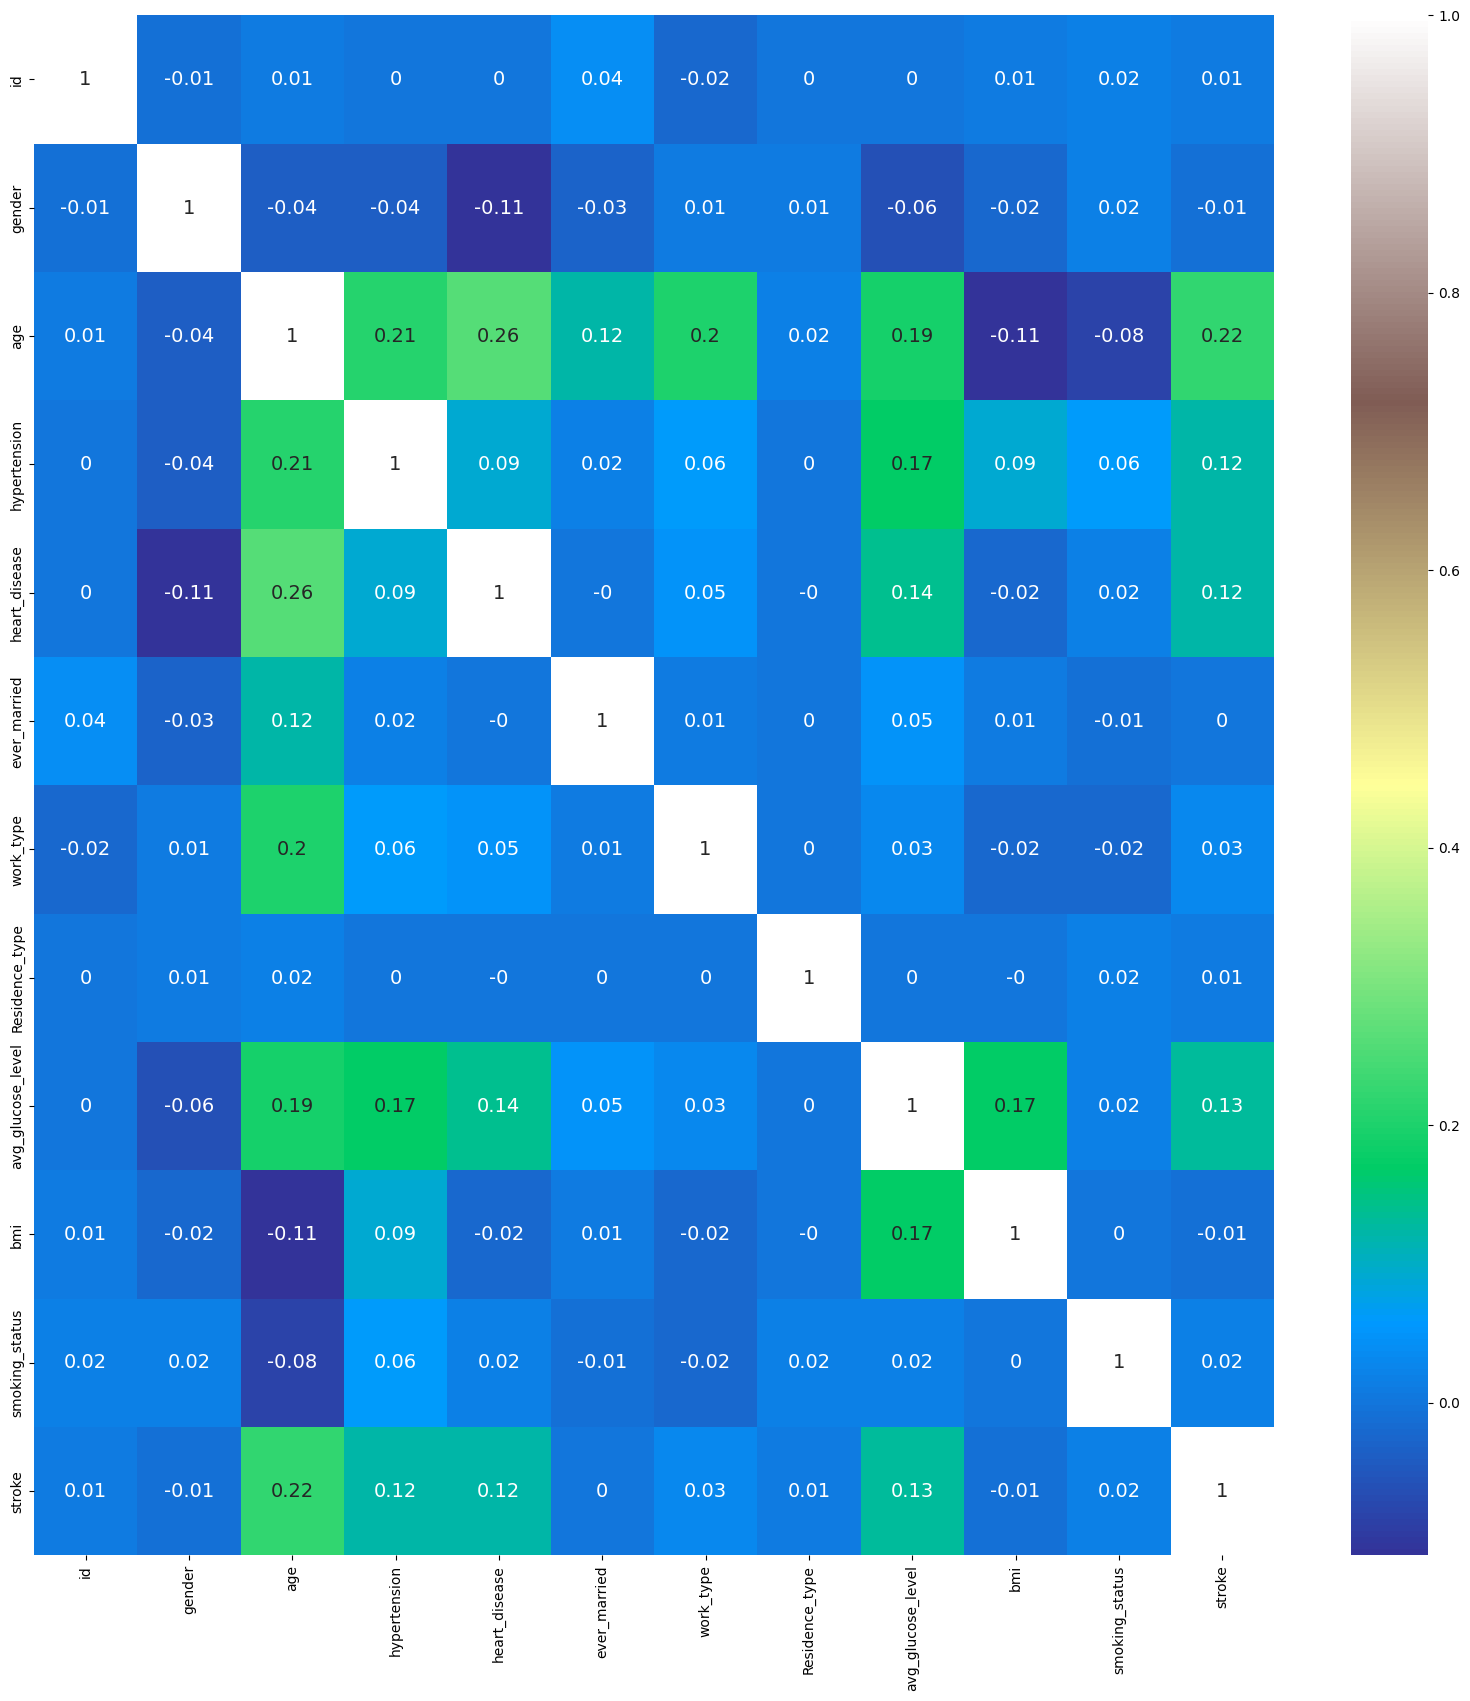

In [ ]:
corr_map_df = clean_df
corr_map_df.work_type = corr_map_df['work_type'].astype('category')
corr_map_df.work_type = corr_map_df['work_type'].cat.codes

corr_map_df.smoking_status = corr_map_df['smoking_status'].astype('category')
corr_map_df.smoking_status = corr_map_df['smoking_status'].cat.codes

plt.figure(figsize = (20,20))
sns.heatmap(round(corr_map_df.corr(),2), cmap = "terrain", annot = True, annot_kws = {"size":14})
# hsv terrain jet rainbow tab10 Pastel1 Set3 RdBu viridis inferno plasma cividis magma

without class balance

In [ ]:



# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['work_type', 'smoking_status' ]
to_robust = ['age', 'avg_glucose_level', 'bmi']
# to_min_max = []
already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(500):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', RobustScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', class_weight='balanced'))  # Linear Regression model
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 10
# Mean Recall: 0.71082
# Mean r2 Test_Score: 0.70177
# Average prediction error: ~0.5460 (RMSE)
min/max recall result[0.5087719298245614, 0.8709677419354839]


with undersampling

In [ ]:

class_0_df = clean_df[clean_df['stroke'] == 0]
class_1_df = clean_df[clean_df['stroke'] == 1]

undersampled_class_0_data = class_0_df.sample(n=len(class_1_df), random_state=42)
clean_df = pd.concat([undersampled_class_0_data, class_1_df])
clean_df = clean_df.sample(frac=1, random_state=42)

# Now, 'undersampled_data' contains an undersampled version of your original dataset


In [ ]:



# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['work_type', 'smoking_status' ]
to_robust = ['age', 'avg_glucose_level', 'bmi']
# to_min_max = []
already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(500):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', RobustScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2'))  # Linear Regression model
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 10
# Mean Recall: 0.00546
# Mean r2 Test_Score: 0.93861
# Average prediction error: ~0.2474 (RMSE)
min/max recall result[0.0, 0.05555555555555555]


With both undersampling and oversampling

In [327]:

class_0_df = clean_df[clean_df['stroke'] == 0]
class_1_df = clean_df[clean_df['stroke'] == 1]

undersampled_class_0_data = class_0_df.sample(n=len(class_1_df)*2, replace=True, random_state=42)
clean_df = pd.concat([class_1_df, undersampled_class_0_data, class_1_df])
clean_df = clean_df.sample(frac=1, random_state=42)

# Now, 'undersampled_data' contains an undersampled version of your original dataset


In [328]:



# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['work_type', 'smoking_status' ]
to_robust = ['age', 'avg_glucose_level', 'bmi']
# to_min_max = []
already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=1000, verbose = 0, n_jobs=4))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 10
# Mean Recall: 0.73791
# Mean r2 Test_Score: 0.72768
# Average prediction error: ~0.5214 (RMSE)
min/max recall result[0.6666666666666666, 0.8032786885245902]


One by One Features

In [ ]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]
    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
    clean_df = clean_df.dropna(axis=0, subset='bmi')


In [ ]:
# clean_df

Categorical

In [ ]:
# %%writefile my_python_file.py
# All Columns to preprocess
# to_classify = ['work_type', 'smoking_status' ]
# to_robust = ['age', 'avg_glucose_level', 'bmi']
# # to_min_max = []
# already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
# select_features = ['work_type'] # + to_min_max
select_features = ['smoking_status']

X = clean_df[select_features]
y = clean_df['stroke']  # Target
r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), select_features),
        # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=100, class_weight='balanced'))  # Linear Regression model class_weight='balanced' , n_jobs=4
    ])
    # print(f"{X_train, y_train}")
    pipeline.fit(X_train, y_train)
    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1
# Mean Recall: 0.47654
# Mean r2 Test_Score: 0.54585
# Average prediction error: ~0.6629 (RMSE)
min/max recall result[0.18518518518518517, 0.8769230769230769]


First attempts :

work_type : 0.42

smoking_status : 0.49


Numericals

In [ ]:

# %%writefile my_python_file.py
# All Columns to preprocess
# to_classify = ['work_type', 'smoking_status' ]
# to_robust = ['age', 'avg_glucose_level', 'bmi']
# # to_min_max = []
# already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
# select_features = ['work_type'] # + to_min_max
select_features = ['bmi']

X = clean_df[select_features]
y = clean_df['stroke']  # Target
r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', MinMaxScaler(), select_features),
        # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=100, class_weight='balanced'))  # Linear Regression model class_weight='balanced' , n_jobs=4
    ])
    # print(f"{X_train, y_train}")
    pipeline.fit(X_train, y_train)
    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1
# Mean Recall: 0.53138
# Mean r2 Test_Score: 0.46182
# Average prediction error: ~0.7332 (RMSE)
min/max recall result[0.2537313432835821, 0.6491228070175439]


First attempts :

age : 0.67

avg_glucose_level : 0.42

bmi : 0.55574


Binaries

In [ ]:
# %%writefile my_python_file.py
# All Columns to preprocess
# to_classify = ['work_type', 'smoking_status' ]
# to_robust = ['age', 'avg_glucose_level', 'bmi']
# # to_min_max = []
# already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
# select_features = ['work_type'] # + to_min_max
select_features = ['Residence_type']

X = clean_df[select_features]
y = clean_df['stroke']  # Target
r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), select_features),
        # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=100, class_weight='balanced'))  # Linear Regression model class_weight='balanced' , n_jobs=4
    ])
    # print(f"{X_train, y_train}")
    pipeline.fit(X_train, y_train)
    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1
# Mean Recall: 0.48088
# Mean r2 Test_Score: 0.49431
# Average prediction error: ~0.7111 (RMSE)
min/max recall result[0.38181818181818183, 0.5714285714285714]


First attempts :

gender : 0.42

hypertension : 0.28

heart_disease : 0.19

ever_married : 0.42845

Residence_type : 0.49


work_type : 0.42

smoking_status : 0.49





age : 0.67

avg_glucose_level : 0.42

bmi : 0.55574




gender : 0.42

hypertension : 0.28

heart_disease : 0.19

ever_married : 0.42845

Residence_type : 0.49

In [ ]:
features_to_keep = ['age', 'bmi', 'smoking_status', 'Residence_type']


Regression with proper features

In [ ]:
# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
# to_min_max = []
already_processed = ['Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 4 - ['smoking_status', 'age', 'bmi', 'Residence_type']
# Mean Recall: 0.71772
# Mean r2 Test_Score: 0.68858
# Average prediction error: ~0.5579 (RMSE)
min/max recall result[0.6, 0.8166666666666667]


In [ ]:
# %%writefile my_python_file.py
# All Columns to preprocess
to_robust = ['age', 'bmi']
# to_min_max = []
# Bench : 'MiscFeature'
select_features = to_robust # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('robust_scaler', MinMaxScaler(), to_robust) # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 2 - ['age', 'bmi']
# Mean Recall: 0.70349
# Mean r2 Test_Score: 0.67949
# Average prediction error: ~0.5660 (RMSE)
min/max recall result[0.5892857142857143, 0.8448275862068966]


# RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification
# X, y = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                            random_state=0, shuffle=False)



# clf = RandomForestClassifier(max_depth=2, random_state=0)
# clf.fit(X, y)
# print(clf.predict([[0, 0, 0, 0]]))


[1]


In [ ]:

to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
already_processed = ['Residence_type']

select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', RandomForestClassifier(max_depth=1, n_estimators=1000, random_state=0, class_weight='balanced'))
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 4 - ['smoking_status', 'age', 'bmi', 'Residence_type']
# Mean Recall: 0.70671
# Mean r2 Test_Score: 0.65277
# Average prediction error: ~0.5874 (RMSE)
min/max recall result[0.5272727272727272, 0.875]


In [ ]:
from sklearn.tree import DecisionTreeClassifier
import joblib


In [ ]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]
    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
    # clean_df.bmi = clean_df.bmi.apply(lambda x : x if isinstance(x, float) else 0)
    clean_df.bmi.fillna(0, inplace=True)
    clean_df = clean_df[clean_df.bmi <= 60]


In [ ]:

to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
already_processed = ['Residence_type', 'gender']

select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', DecisionTreeClassifier(max_depth=2, random_state=0, class_weight='balanced')) #class_weight
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)


    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))
    if recall_list[-1] == max(recall_list) :
        joblib.dump(pipeline, 'app/app_model/model.pkl')

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 5 - ['smoking_status', 'age', 'bmi', 'Residence_type', 'gender']
# Mean Recall: 0.79370
# Mean r2 Test_Score: 0.60591
# Average prediction error: ~0.6249 (RMSE)
min/max recall result[0.4117647058823529, 0.9487179487179487]


# Script

In [ ]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]
    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
    # clean_df.bmi = clean_df.bmi.apply(lambda x : x if isinstance(x, float) else 0)
    clean_df.bmi.fillna(0, inplace=True)
    clean_df = clean_df[clean_df.bmi <= 60]


In [ ]:
clean_df.smoking_status

0       formerly smoked
1          never smoked
2          never smoked
3                smokes
4          never smoked
             ...       
5105       never smoked
5106       never smoked
5107       never smoked
5108    formerly smoked
5109            Unknown
Name: smoking_status, Length: 3531, dtype: object

In [ ]:
df.smoking_status

0       formerly smoked
1          never smoked
2          never smoked
3                smokes
4          never smoked
             ...       
5105       never smoked
5106       never smoked
5107       never smoked
5108    formerly smoked
5109            Unknown
Name: smoking_status, Length: 5110, dtype: object

In [ ]:


select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', DecisionTreeClassifier(max_depth=2, random_state=0, class_weight='balanced')) #class_weight
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

In [338]:
clean_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1453,4692,1,74.0,0,0,1,Govt_job,1,251.99,25.5,never smoked,0
234,25974,0,78.0,0,0,1,Self-employed,1,218.46,26.8,Unknown,1
3296,64742,0,48.0,0,0,0,Self-employed,0,64.18,32.1,never smoked,0
1481,10943,1,40.0,0,0,1,Govt_job,0,110.60,33.3,formerly smoked,0
205,51314,1,78.0,0,0,1,Private,1,106.74,33.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
88,14499,0,47.0,0,0,1,Private,1,86.94,41.1,formerly smoked,1
127,70943,1,80.0,0,0,1,Private,1,73.54,24.0,Unknown,1
4868,29734,1,45.0,0,0,0,Govt_job,0,77.45,42.2,formerly smoked,0
2804,51342,1,69.0,0,0,1,Govt_job,0,70.98,30.0,Unknown,0


# Learning curve


In [329]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

In [331]:
# # %%writefile my_python_file.py
# # All Columns to preprocess
# # to_classify = ['work_type', 'smoking_status' ]
# # to_robust = ['age', 'avg_glucose_level', 'bmi']
# # # to_min_max = []
# # already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# # Bench : 'MiscFeature'
# # select_features = ['work_type'] # + to_min_max
# select_features = ['Residence_type']

# X = clean_df[select_features]
# y = clean_df['stroke']  # Target
# r2list = []
# rmse_list = []
# recall_list = []

# # allow more accurate model's performance estimation with more training reps and
# # different data splits on a small amount of data, needs to be 1 for prediction tasks.
# for i in range(50):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
#         random_state=np.random.randint(1, 20001))

#     # Building Pipeline
#     preprocessor = ColumnTransformer([
#         ('onehot', OneHotEncoder(), select_features),
#         # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
#         # ('minmax', MinMaxScaler(), to_min_max),
#     ], remainder='passthrough')  # passthrough/drop

#     pipeline = Pipeline([
#         ('preprocessor', preprocessor),
#         ('regressor', learning_curve(estimator=SVR, X=X_test, y=y_test, cv=5))  # Linear Regression model class_weight='balanced' , n_jobs=4
#     ])
#     # print(f"{X_train, y_train}")
#     pipeline.fit(X_train, y_train)
#     r2list.append(pipeline.score(X_test, y_test))

#     predicted_strokes = pipeline.predict(X_test)
#     rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
#     recall_list.append(recall_score(y_test, predicted_strokes))

# print(f"# Used features count : {len(select_features)}") #/len(df.columns)
# print(f"# Mean Recall: {np.mean(recall_list):.5f}")
# print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# # Display RMSE
# print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


# print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Script

In [178]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]
    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
    # clean_df.bmi = clean_df.bmi.apply(lambda x : x if isinstance(x, float) else 0)
    clean_df.bmi.fillna(0, inplace=True)
    clean_df = clean_df[clean_df.bmi <= 60]


In [181]:
clean_df.smoking_status

0       formerly smoked
1          never smoked
2          never smoked
3                smokes
4          never smoked
             ...       
5105       never smoked
5106       never smoked
5107       never smoked
5108    formerly smoked
5109            Unknown
Name: smoking_status, Length: 3531, dtype: object

In [176]:
df.smoking_status

0       formerly smoked
1          never smoked
2          never smoked
3                smokes
4          never smoked
             ...       
5105       never smoked
5106       never smoked
5107       never smoked
5108    formerly smoked
5109            Unknown
Name: smoking_status, Length: 5110, dtype: object

In [ ]:


select_features = to_classify + to_robust + already_processed # + to_min_max

X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', DecisionTreeClassifier(max_depth=2, random_state=0, class_weight='balanced')) #class_weight
        # ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")